#  <font color='DarkOrange'>0. Connect between Kaggle dataset and colab </font>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eslamzoghla","key":"dc09c4d807a162502eddc462a08d37fa"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57          16169        506  1.0              
prasad22/daily-transactions-dataset                        Daily Transactions Dataset                      34KB  2023-09-25 02:32:21            687         30  1.0              
joebeachcapital/students-performance                       Students Performance                             2KB  2023-08-31 00:50:11           5707        141  1.0              
carlmcbrideellis/zzzs-lightweight-training-dataset-target  Zzzs: Lightweight training dataset + target    185M

In [ ]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 202MB/s]


In [ ]:
! unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

#  <font color='DarkOrange'>1. Import Librarys </font>

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from tqdm import tqdm
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import regularizers
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#  <font color='DarkOrange'>2. Read data </font>

In [ ]:
data_dir = '/content/brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in tqdm(filelist):
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

100%|██████████| 98/98 [00:00<00:00, 203184.28it/s]


#  <font color='DarkOrange'>3. Exploratory Data Analysis (EDA)</font>

##  <font color='DarkOrange'>3.1. Train and test split </font>

In [ ]:
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [ ]:
print(test_df.head())

                                     filepaths labels
160  /content/brain_tumor_dataset/no/no 95.jpg     no
24    /content/brain_tumor_dataset/yes/Y30.jpg    yes
107  /content/brain_tumor_dataset/yes/Y184.JPG    yes
229    /content/brain_tumor_dataset/no/N26.JPG     no
205  /content/brain_tumor_dataset/no/no 90.jpg     no


##  <font color='DarkOrange'>3.2. Shown Image </font>

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


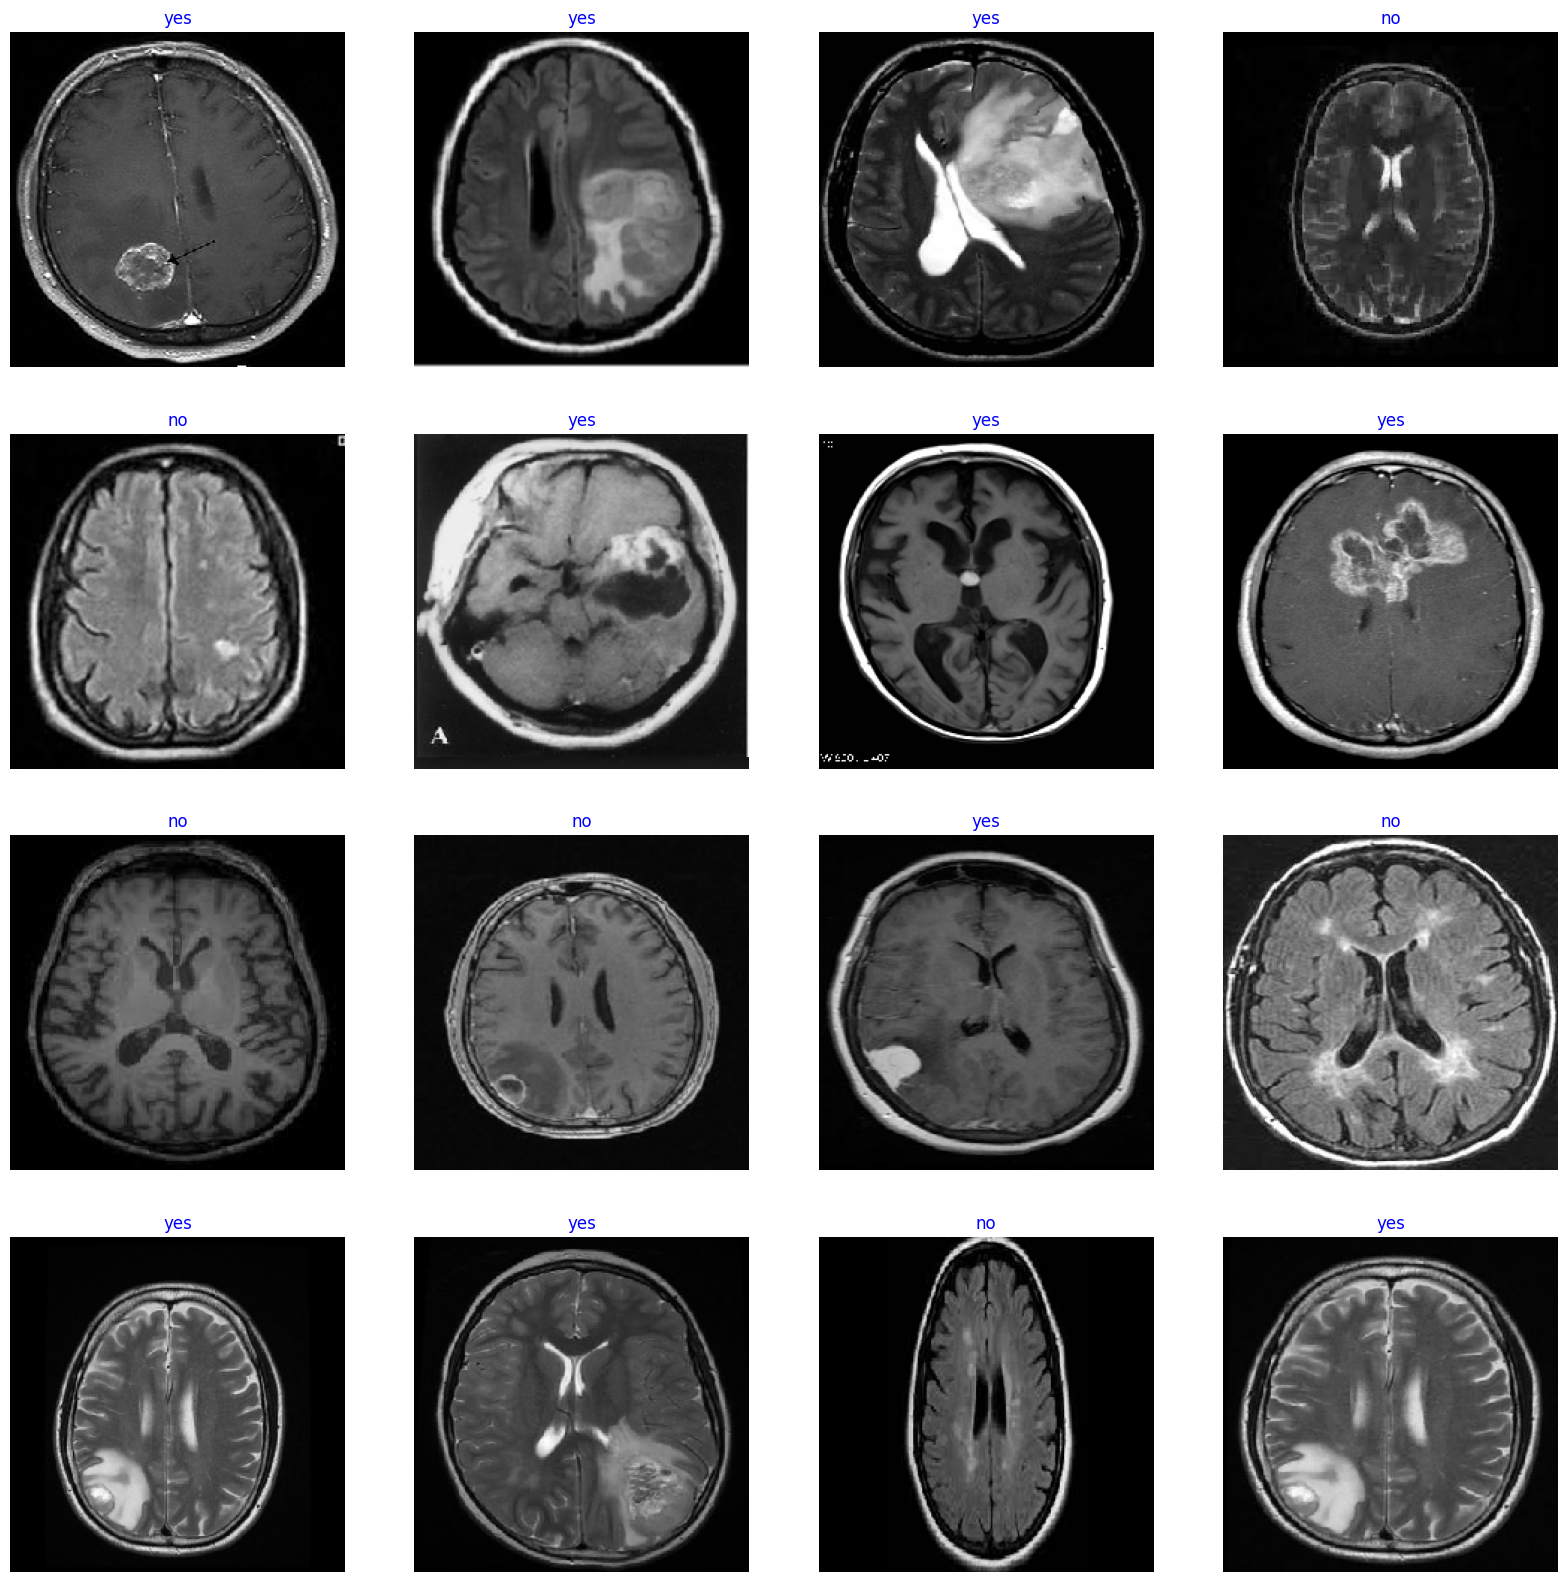

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#  <font color='DarkOrange'>4. Build Model </font>

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001),  'binary_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [ ]:
history = model.fit(x= train_gen, epochs= 100, batch_size=32, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/100
13/13 [==============================] - 53s 368ms/step - loss: 7.8173 - accuracy: 0.7871 - val_loss: 7.9483 - val_accuracy: 0.8800
Epoch 2/100
13/13 [==============================] - 2s 143ms/step - loss: 6.8534 - accuracy: 0.9356 - val_loss: 7.1088 - val_accuracy: 0.8000
Epoch 3/100
13/13 [==============================] - 2s 158ms/step - loss: 6.1807 - accuracy: 0.9851 - val_loss: 6.4433 - val_accuracy: 0.8800
Epoch 4/100
13/13 [==============================] - 2s 146ms/step - loss: 5.6616 - accuracy: 0.9653 - val_loss: 5.9231 - val_accuracy: 0.8800
Epoch 5/100
13/13 [==============================] - 2s 144ms/step - loss: 5.1776 - accuracy: 0.9802 - val_loss: 5.4126 - val_accuracy: 0.8800
Epoch 6/100
13/13 [==============================] - 2s 144ms/step - loss: 4.7440 - accuracy: 0.9901 - val_loss: 5.0062 - val_accuracy: 0.8800
Epoch 7/100
13/13 [==============================] - 2s 141ms/step - loss: 4.3437 - accuracy: 0.9901 - val_loss: 4.5405 - val_accuracy: 0.920

#  <font color='DarkOrange'>5. Evaluate Model </font>

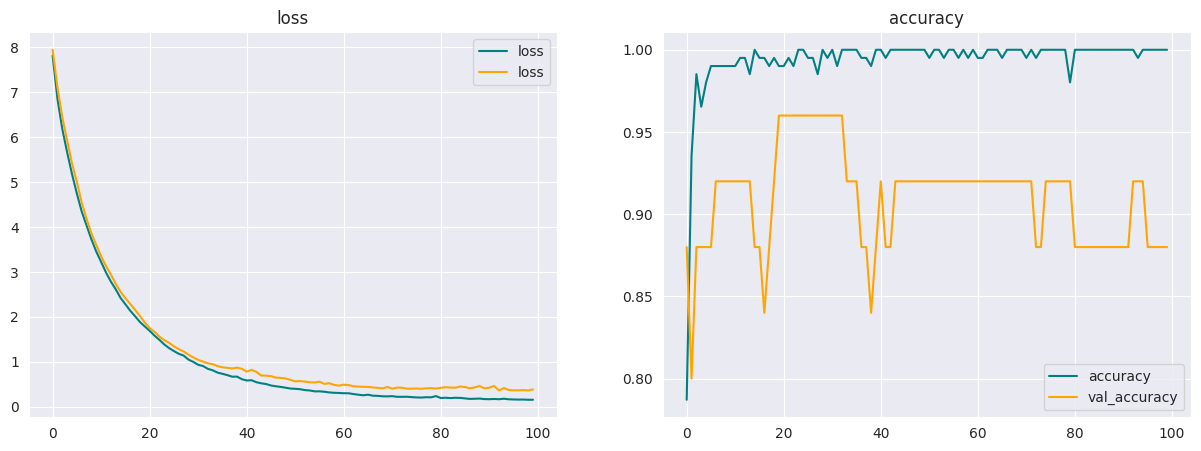

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

##  <font color='DarkOrange'>5.1. Confusion Matrix </font>

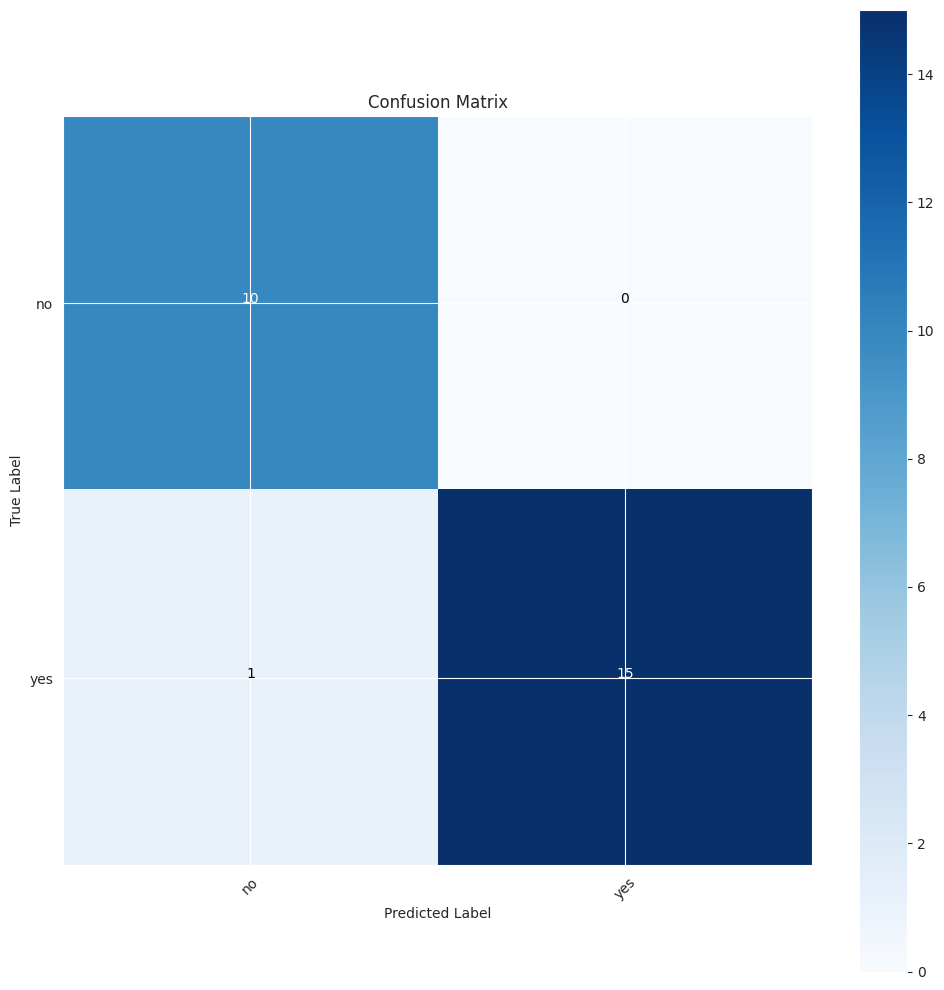

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

##  <font color='DarkOrange'>5.2. Classification Report </font>

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 50)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 0s 29ms/step - loss: 0.2091 - accuracy: 0.9615
Train Loss:  0.13857856392860413
Train Accuracy:  1.0
--------------------------------------------------
Test Loss:  0.2090977132320404
Test Accuracy:  0.9615384340286255


#  <font color='DarkOrange'>+5. Model Improvement</font>
  => using Pre-train model VGG16

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.6)
val_size = int(len(data)*.3)
test_size = int(len(data)*.3)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 253 files belonging to 2 classes.


In [ ]:
# Load the pre-trained VGG16 model
vgg_model = VGG16(
weights='imagenet',
include_top=False,
input_shape=(256,256,3)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(vgg_model)

model.add(Conv2D(16, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
%%time

history_vgg = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[early_stopping]
)

Epoch 1/30
4/4 [==============================] - 11s 593ms/step - loss: 0.6734 - accuracy: 0.6094 - val_loss: 0.6318 - val_accuracy: 0.6406
Epoch 2/30
4/4 [==============================] - 2s 428ms/step - loss: 0.6209 - accuracy: 0.5938 - val_loss: 0.6051 - val_accuracy: 0.6562
Epoch 3/30
4/4 [==============================] - 2s 501ms/step - loss: 0.5365 - accuracy: 0.7422 - val_loss: 0.5738 - val_accuracy: 0.7188
Epoch 4/30
4/4 [==============================] - 2s 418ms/step - loss: 0.4940 - accuracy: 0.7891 - val_loss: 0.4503 - val_accuracy: 0.7969
Epoch 5/30
4/4 [==============================] - 2s 415ms/step - loss: 0.3680 - accuracy: 0.8828 - val_loss: 0.4112 - val_accuracy: 0.8125
Epoch 6/30
4/4 [==============================] - 2s 609ms/step - loss: 0.3469 - accuracy: 0.8828 - val_loss: 0.3950 - val_accuracy: 0.8281
Epoch 7/30
4/4 [==============================] - 2s 411ms/step - loss: 0.2695 - accuracy: 0.9062 - val_loss: 0.2900 - val_accuracy: 0.9062
Epoch 8/30
4/4 [===

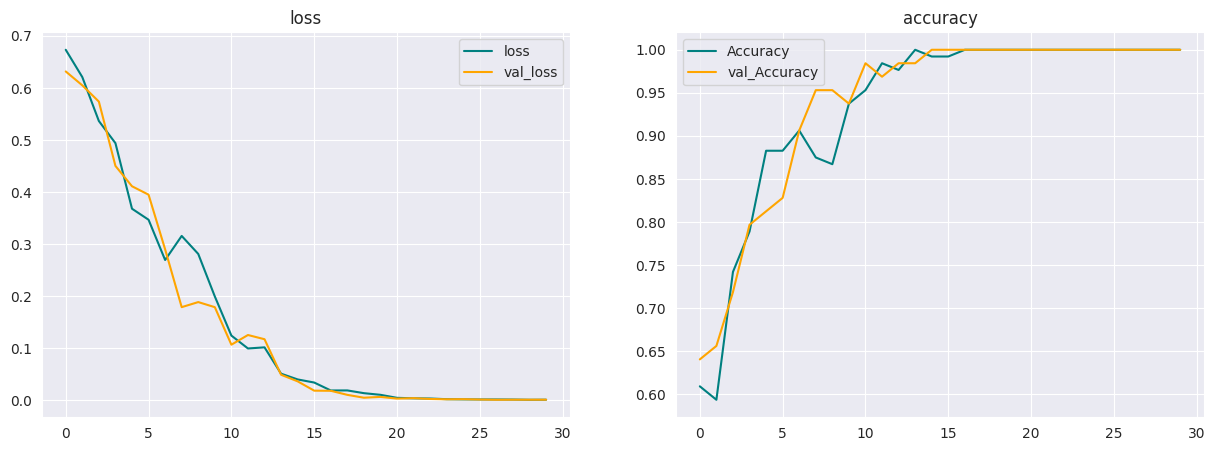

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['loss'], color='teal', label='loss')
plt.plot(history_vgg.history['val_loss'], color='orange', label='val_loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg.history['accuracy'], color='teal', label='Accuracy')
plt.plot(history_vgg.history['val_accuracy'], color='orange', label='val_Accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

#  <font color='DarkOrange'>6. Predict </font>

##  <font color='DarkOrange'>6.1. Prediction on Train</font>

In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in train.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 44ms/step
Precision (Train-Set) : 1.0
Recall (Train-Set) : 1.0
Accuracy (Train-Set) : 1.0


##  <font color='DarkOrange'>6.2. Prediction on Test</font>

In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Test-Set) : {precision.result()}')
print(f'Recall (Test-Set) : {recall.result()}')
print(f'Accuracy (Test-Set) : {accuracy.result()}')

1/1 [==============================] - 5s 5s/step
Precision (Test-Set) : 1.0
Recall (Test-Set) : 1.0
Accuracy (Test-Set) : 1.0


#  <font color='DarkOrange'>7. Save Model </font>

In [ ]:
# Save this model as H5
model.save('brain_tumor_model.h5')